In [5]:
import numpy as np
import theano
import theano.tensor as TT
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
#number of hidden units
nHidden = 20
#number of inputs
nInputs = 4
#number of outputs
nOutputs = 4

#input (first dimension is time)
u = TT.matrix("u")
#target (first dimension is time)
t = TT.matrix("t")
#initial hidden state of the RNN 
h0 = TT.vector("h0")
#learning rate
lr = TT.scalar("lr")
#recurrent weights as a shared variable
W = theano.shared(np.random.uniform(size = (nHidden, nHidden), low = -.01, high = .01))
#input to hidden layer weights
W_in = theano.shared(np.random.uniform(size = (nInputs, nHidden), low = -.01, high = .01))
#hidden to output layer weights
W_out = theano.shared(np.random.uniform(size = (nHidden, nInputs), low = -.01, high = .01))

#recurrent function (tanh) and tanh output activation function
def step(u_t, h_tm1, W, W_in, W_out):
    h_t = TT.tanh(TT.dot(u_t, W_in) + TT.dot(h_tm1, W))
    y_t = TT.tanh(TT.dot(h_t, W_out))
    return h_t, y_t

In [60]:
#hidden state for entire sequence and the output for the entire sequence
[h, y], _ = theano.scan(step, 
                       sequences = u,
                       outputs_info = [h0, None], 
                       non_sequences = [W, W_in, W_out])


In [61]:
# 1 step of sgd
error = ((y-t)**2).sum()
gW, gW_in, gW_out = TT.grad(error, [W, W_in, W_out])
#training funciotn computs the gradients according to penalty in error...

fn = theano.function([h0, u, t, lr], 
                    error, 
                    updates = {W: W - lr*gW,
                              W_in: W_in - lr*gW_in,
                              W_out: W_out - lr*gW_out})


/Users/ameliachristensen/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <type 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.python2x.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.


In [72]:
#generate simulated data

numExamples = 10000

data = np.zeros([numExamples, 4])

for i in xrange(0, numExamples, 3):
    data[i] = np.random.randint(0, 2, [1,4])

for i in xrange(3, numExamples, 6):
    data[i][0] = 0
    
for i in xrange(0, numExamples, 6):
    data[i][0] = 1
    
target = np.zeros([numExamples, 4])
memory = np.zeros([1, 3])

for idx, record in enumerate(data):
    
    if record[0] == 1:
        memory = record[1:4]
    elif all(memory == record[1:4]):
        target[idx][0] = 1
        
    target[idx][1:4] = memory
    
#   print record, memory, target[idx]
    
init = np.random.randint(0, 2, [nHidden])    


In [76]:
err = np.zeros([numExamples, 1])
for i in range(numExamples):
    err[i] = fn(init, data, target, 0.01)

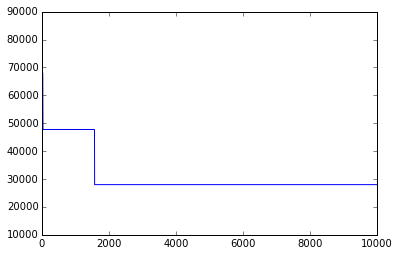

In [77]:
plt.plot(err)